In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
import copy

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sns.set_style()

In [6]:
device = 'cuda'

In [7]:
imsize = 512

loader = transforms.Compose(
    [
        transforms.Resize((imsize, imsize)),
        transforms.ToTensor(),
    ]
)


def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [244]:
!wget https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
!wget https://i.ibb.co/ZNv8zXm/photo-2020-08-25-09-24-33.jpg

style_img = image_loader("/content/asuh1.jpg")
content_img = image_loader("/content/aaa.jpg")

assert (
    style_img.size() == content_img.size()
), "We need to import style and content images of the same size"

--2023-11-26 20:02:37--  https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
Resolving pytorch.org (pytorch.org)... 185.199.109.153, 185.199.108.153, 185.199.111.153, ...
Connecting to pytorch.org (pytorch.org)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114573 (112K) [image/jpeg]
Saving to: ‘picasso.jpg.12’

picasso.jpg.12      100%[===================>] 111.89K  --.-KB/s    in 0.03s   

2023-11-26 20:02:37 (4.18 MB/s) - ‘picasso.jpg.12’ saved [114573/114573]

--2023-11-26 20:02:37--  https://i.ibb.co/ZNv8zXm/photo-2020-08-25-09-24-33.jpg
Resolving i.ibb.co (i.ibb.co)... 104.243.38.177, 104.243.38.202
Connecting to i.ibb.co (i.ibb.co)|104.243.38.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55973 (55K) [image/jpeg]
Saving to: ‘photo-2020-08-25-09-24-33.jpg.12’

photo-2020-08-25-09 100%[===================>]  54.66K  --.-KB/s    in 0.06s   

2023-11-26 20:02:38 (896 KB/s) - ‘photo-2020-08-25-09

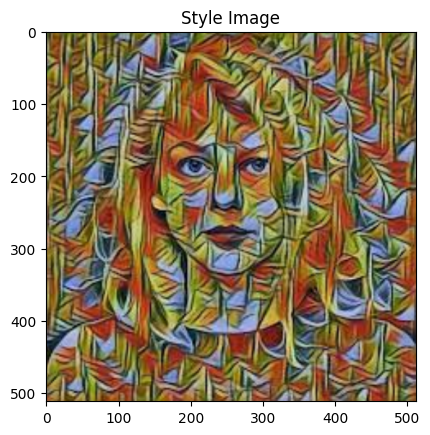

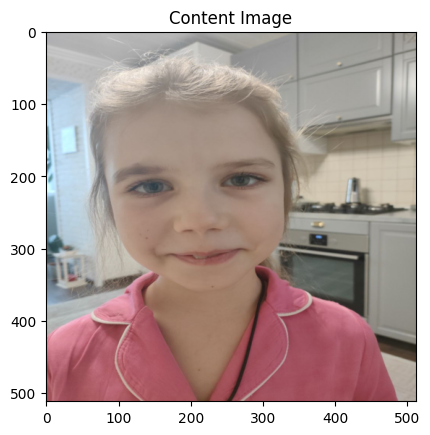

In [245]:
def imshow(tensor, title=None):
    plt.figure()
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


imshow(style_img, title="Style Image")
imshow(content_img, title="Content Image")

In [174]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [175]:
def gram_matrix(input: torch.Tensor) -> torch.Tensor:
    (
        batch_size,
        num_of_fm,
        h,
        w,
    ) = input.size()

    features = input.view(batch_size * num_of_fm, h * w)

    G = torch.matmul(features, features.t())

    return G.div(batch_size * num_of_fm * h * w)

In [176]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super().__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

    def __mul__(self, rhs):
        return self.loss * rhs

In [100]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [177]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).clone().detach().view(-1, 1, 1)
        self.std = torch.tensor(std).clone().detach().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [291]:
content_layers_default = ["conv_4"]
style_layers_default = ["conv_1", "conv_2", "conv_3", "conv_4", "conv_5", 'conv_6', 'conv_7', \
                        'conv_8', 'conv_9', "conv_10", "conv_11", "conv_12", 'conv_13', 'conv_14', \
                        'conv_15', 'conv_16']

def get_style_model_and_losses(
    cnn: nn.Module,
    normalization_mean: torch.Tensor,
    normalization_std: torch.Tensor,
    style_img: torch.Tensor,
    content_img: torch.Tensor,
    content_layers: list[str] = content_layers_default,
    style_layers: list[str] = style_layers_default,
) -> tuple[nn.Module, list[torch.Tensor], list[torch.Tensor]]:
    cnn = copy.deepcopy(cnn)

    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f"conv_{i}"
        elif isinstance(layer, nn.ReLU):
            name = f"relu_{i}"
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f"pool_{i}"
        elif isinstance(layer, nn.BatchNorm2d):
            name = f"bn_{i}"
        else:
            raise RuntimeError(f"Unrecognized layer: {layer.__class__.__name__}")

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[: (i + 1)]

    return model, style_losses, content_losses

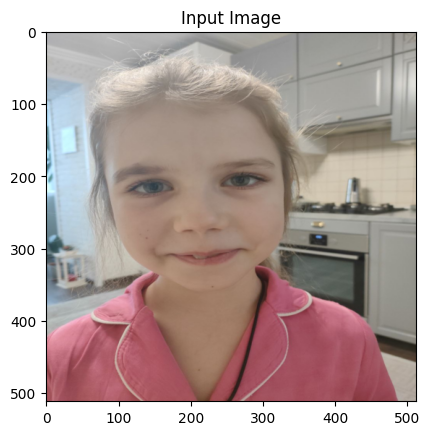

In [297]:
input_img = content_img.clone()

imshow(input_img, title="Input Image")

In [298]:
def get_input_optimizer(input_img: torch.Tensor) -> torch.optim.Optimizer:
    optimizer = torch.optim.LBFGS([input_img.requires_grad_()]) ########## change it to AdamW just for check
    return optimizer

In [299]:
style_weights = [1, 0.75, 0.5, 0.2, 0.2, 0.1, 0.08, 0.06, 0.04, 0.04, \
                 0.04, 0.04, 0.02, 0.02, 0.02, 0.01]
#content_weights = [0, 0, 0, 0, 1, 1, 1, 1, 1]

def run_style_transfer(
    cnn: nn.Module,
    normalization_mean: torch.Tensor,
    normalization_std: torch.Tensor,
    style_img: torch.Tensor,
    content_img: torch.Tensor,
    input_img: torch.Tensor,
    num_steps: int = 30,
    style_weight: float = 1000000.0,
    content_weight: float = 1.0,
) -> torch.Tensor:
    print("Building the style transfer model...")

    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print("Optimizing...")

    style_score_hist = []
    content_score_hist = []
    for step in range(num_steps):

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)

            style_score = 0
            for sl, score in zip(style_losses, style_weights):
                style_score += (sl.loss * score)
            style_score *= style_weight

            #content_score = 0
            #for sl, score in zip(content_losses, content_weights):
            #    content_score += (sl.loss * score)
            #content_score *= content_weight

            content_score = content_weight * sum([c.loss for c in content_losses])
            loss = style_score + content_score
            style_score_hist.append(style_score)
            content_score_hist.append(content_score)
            loss.backward()

            return loss

        optimizer.step(closure)

        if (step) % 5 == 0:
            print(f"Step number: {step + 1}")
            print(
                f"Style Loss : {style_score_hist[-1].item():.4f} Content Loss: {content_score_hist[-1].item():.4f}"
            )

    input_img.data.clamp_(0, 1)

    return input_img

In [300]:
output = run_style_transfer(
    cnn,
    cnn_normalization_mean,
    cnn_normalization_std,
    style_img,
    content_img,
    input_img,
    style_weight=1_000_000,
)

Building the style transfer model...
Optimizing...


<ipython-input-177-1b4541de7bef>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).clone().detach().view(-1, 1, 1)
<ipython-input-177-1b4541de7bef>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).clone().detach().view(-1, 1, 1)


Step number: 1
Style Loss : 1857.0155 Content Loss: 15.9469
Step number: 6
Style Loss : 79.5087 Content Loss: 20.0071
Step number: 11
Style Loss : 31.9557 Content Loss: 20.2572
Step number: 16
Style Loss : 16.9950 Content Loss: 19.7471
Step number: 21
Style Loss : 9.6019 Content Loss: 19.2266
Step number: 26
Style Loss : 5.8820 Content Loss: 18.6254


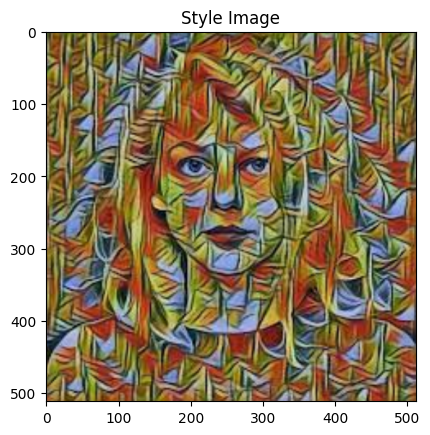

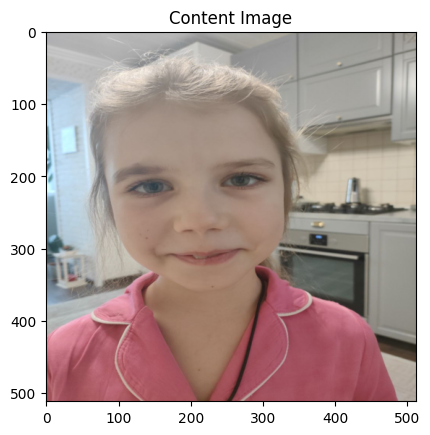

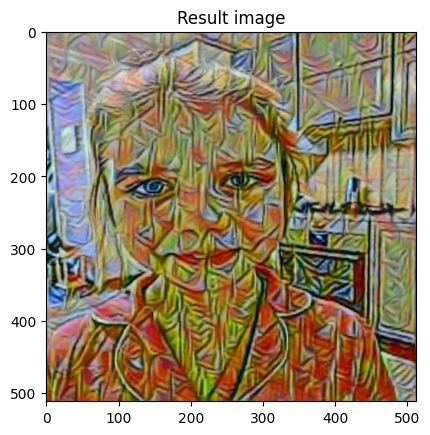

In [301]:
imshow(style_img, title="Style Image")
imshow(content_img, title="Content Image")
imshow(output, title="Result image")